# ResNet50 Model 

In [39]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

# Custom Dependencies (for ResNet50)
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

In [22]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices: 
    print("GPU is available") 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available") 

GPU is not available


### Load and Pre-process FER2013 Dataset

In [23]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

# Define the Image Size and Parameters
img_size = (48, 48)
input_shape = (48, 48, 3)
batch_size = 64

## Trial #3: ResNet50 with Pretrained Weights

### Create Data Generators 

In [ ]:
# Data Preprocessing and augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator 
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Load ResNet50 Base with ImageNet Weights

In [25]:
# Add class weights 
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [26]:
# Define ResNet50V2 model (pretrained w/ Imagenet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model (for now)
for layer in base_model.layers:
    layer.trainable = False

### Define the ResNet Model

In [27]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=base_model.input, outputs=output)

In [28]:
# Create a loss function that is appropriate for multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the ResNet Model 
model_3.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy'])

initial_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

### Train the Model

#### Phase 1: Inital Training

In [29]:
# Start the initial training
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


382/382 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.1367 - loss: 2.0226 - val_accuracy: 0.1934 - val_loss: 1.9418 - learning_rate: 0.0010
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.0297 - loss: 1.9639 - val_accuracy: 0.0153 - val_loss: 1.9475 - learning_rate: 0.0010
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.1168 - loss: 1.9402 - val_accuracy: 0.0167 - val_loss: 1.9484 - learning_rate: 0.0010
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.1175 - loss: 1.9269 - val_accuracy: 0.0151 - val_loss: 1.9496 - learning_rate: 0.0010
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.0655 - loss: 1.9407 - val_accuracy: 0.0158 - val_loss: 1.9485 - learning_rate: 5.0000e-04
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.0829 - loss: 1.9238 - val_accuracy: 0.0151 - val_loss: 1.9479 - learning_rate: 5.0000e-04
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.0896

#### Phase 2: Final Training (unfreeze and fine-tune)

In [30]:
# Fine-tune the model (unfreeze the last 50% of ResNet50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True


# Compile (adding a lower learning rate)
model_3.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss_fn,
              metrics=['accuracy'])

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Continue training (fine-tune entire model)
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 145s 368ms/step - accuracy: 0.1647 - loss: 2.1062 - val_accuracy: 0.1694 - val_loss: 1.9408 - learning_rate: 1.0000e-05
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 145s 380ms/step - accuracy: 0.1589 - loss: 1.9998 - val_accuracy: 0.1608 - val_loss: 1.9475 - learning_rate: 1.0000e-05
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 152s 398ms/step - accuracy: 0.1589 - loss: 1.9966 - val_accuracy: 0.1845 - val_loss: 1.9262 - learning_rate: 1.0000e-05
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 147s 385ms/step - accuracy: 0.1658 - loss: 1.9683 - val_accuracy: 0.1759 - val_loss: 1.9310 - learning_rate: 1.0000e-05
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 148s 388ms/step - accuracy: 0.1596 - loss: 1.9534 - val_accuracy: 0.1843 - val_loss: 1.9323 - learning_rate: 1.0000e-05
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 148s 387ms/step - accuracy: 0.1691 - loss: 1.9392 - val_accuracy: 0.1971 - val_loss: 1.9255 - learning_rate: 1.0000e-05
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 

In [36]:
# Save the weights
model_3.save_weights('ResNet50_weights.weights.h5')

### Evaluate

In [1]:
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

NameError: name 'model_3' is not defined

### Plot Training History 

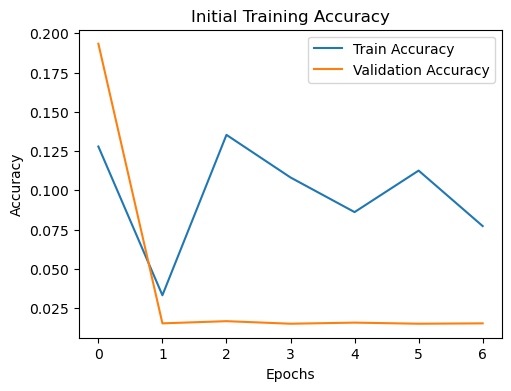

In [34]:
# Plotting the model accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

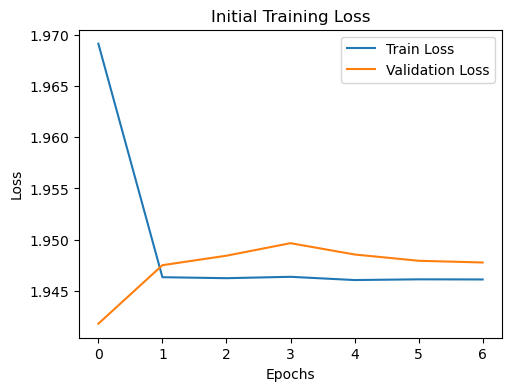

In [35]:
# Plotting the model loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**ResNet50 with ImageNet Weights** (7 classes)

Training Results:
- Accuracy: 
- Loss: 

Test Results:
- Accuracy: 
- Loss: 

**Question: Was this model successful?** No.

**Analysis**: 

## Model #4: ResNet50V2 

### Re-Define Data Generators 

In [ ]:
# Re-define parameters 
img_size = (48, 48)
batch_size = 64
num_classes = 3

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # Use 15% of training data for validation
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',  # ResNet50V2 expects 3-channel RGB images
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

### Load ResNet50V2 (pretrained weights)

In [ ]:
# Define the model architecture 
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)  # 7 emotion classes

model_4 = Model(inputs=base_model.input, outputs=output)

In [40]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False# Freeze the base model layers

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,827,975 (90.90 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [41]:
# Callbacks for training
callbacks_training = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [42]:
# Train the model (custom head only)
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training
)

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.1998 - loss: 12.9946 - val_accuracy: 0.2519 - val_loss: 1.8355 - learning_rate: 1.0000e-04
Epoch 2/20
  1/381 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.2500 - loss: 1.8263

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2500 - loss: 1.8263 - val_accuracy: 0.2516 - val_loss: 1.8345 - learning_rate: 1.0000e-04
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.2560 - loss: 1.8834 - val_accuracy: 0.2516 - val_loss: 1.8400 - learning_rate: 1.0000e-04
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2500 - loss: 1.8293 - val_accuracy: 0.2516 - val_loss: 1.8421 - learning_rate: 1.0000e-04
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.2540 - loss: 1.8747 - val_accuracy: 0.2514 - val_loss: 1.8504 - learning_rate: 1.0000e-04
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3125 - loss: 1.8726 - val_accuracy: 0.2514 - val_loss: 1.8486 - learning_rate: 5.0000e-05
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.2527 - loss: 1.8707 - val_accuracy: 0.2509 - val_loss: 1.8171 - learning_rate: 5.0000e-05
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy

In [43]:
# Unfreeze some layers for fine-tuning (in base model)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_4.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_training,
)

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step - accuracy: 0.2363 - loss: 1.8583 - val_accuracy: 0.1103 - val_loss: 1.9249 - learning_rate: 1.0000e-05
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2500 - loss: 1.8248 - val_accuracy: 0.1101 - val_loss: 1.9242 - learning_rate: 1.0000e-05
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.2360 - loss: 1.8315 - val_accuracy: 0.2516 - val_loss: 1.8204 - learning_rate: 1.0000e-05
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2812 - loss: 1.7928 - val_accuracy: 0.2512 - val_loss: 1.8197 - learning_rate: 1.0000e-05
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/step - accuracy: 0.2411 - loss: 1.8269 - val_accuracy: 0.2514 - val_loss: 1.8109 - learning_rate: 1.0000e-05
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1875 - loss: 1.8411 - val_accuracy: 0.2521 - val_loss: 1.8103 - learning_rate: 1.0000e-05
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 57s 149ms/st

### Evaluate 

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_4.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.2223 - loss: 1.8511
Test Loss: 1.7979, Test Accuracy: 0.2476


In [46]:
# Save the weights
model_4.save_weights('ResNet50V2_weights.weights.h5')

**ResNet50V2 with ImageNet Weights** (7 classes)

Training Results:
- Accuracy: 0.2223
- Loss: 1.8511

Test Results:
- Accuracy: 0.2476
- Loss: 1.7979

**Question: Was this model successful?** No.

**Analysis**: Both training (0.2223) and test accuracy (0.2476) are very low, indicating that the model struggles to learn meaningful patterns for the 7-class classification task. The test accuracy is only slightly better than random guessing (random accuracy for 7 classes is approximately 1/7 ≈ 0.1429), suggesting that the model is not effectively learning the task.

**Conclusion**:
The ResNet50V2 model struggles significantly with the 7-class classification task, achieving only marginally better accuracy than random guessing. This is likely due to the complexity of the task, the limitations of the FER2013 dataset, and the mismatch between the pretrained weights and the dataset domain. Simplifying the task, augmenting the data, and fine-tuning the model could help improve performance.